 <center> <h1> <b> Pattern Recognition and Machine Learning (EE5607) </b> </h1> </center>

<b> Programming Assignment - 04 - Neural Networks</b>

<b> Instructions </b>
1. Plagiarism is strictly prohibited.
2. Delayed submissions will be penalized with a scaling factor of 0.5 per day.
3. Please DO NOT use any machine learning libraries unless and otherwise specified.



<b> Assignment on Neural Networks </b> <br>
This programming assignment gives you a chance to perform the classification task using neural networks. You will get to build a neural network from scratch and train and test it on a standard classification dataset. Further you will learn different tricks and techniques to train a neural network eficiently by observing few important issues and trying to overcome them. This includes observing the performance of the network for different activation functions and optimization algorithms. We will conclude with implementation of various regularization techniques and ResNet to overcome the problems of overfitting and vanishing gradients.

In [1]:
#All imports

import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import collections

%matplotlib notebook

np.random.seed(6996)

<b>  Part - (1) : Train a classification network from scratch </b> 
1. Load MNIST data and create train, test splits
2. Design a simple classification network


> Network should consists of three Dense Layers with 512 nodes. The same architecture is used throughout the assignment to understand the effect of hyper parameters.

> Use stochastic gradient descent optimization algorithm to update the parameters. You can use the learning rate suitable for the MNIST digit classification problem.

> Use ReLU activation function in the first two layers. Softmax activation function should be used at the last layer to get the posterior probability of the classes.






3. Train the network using MNIST training data and evaluate the performance on MNIST test data



In [2]:
##################################################
#Load MNIST data.
##################################################


from mlxtend.data import loadlocal_mnist
import matplotlib.pyplot as plt

# drive.mount('/content/drive',force_remount=True)
# root_path='/content/drive/MyDrive/PRMLAssignments/ProgrammingAssignment-01'
root_path='/home/spcup2022/UDAY/dataset'
train_data_path = str(root_path) + "/" + 'train-images.idx3-ubyte'
train_label_path = str(root_path) + "/" + 'train-labels.idx1-ubyte'
test_data_path = str(root_path) + "/" + 't10k-images.idx3-ubyte'
test_label_path = str(root_path) + "/" + 't10k-labels.idx1-ubyte'
X_train, Y_train = loadlocal_mnist(images_path=train_data_path, labels_path=train_label_path)
X_test, Y_test = loadlocal_mnist(images_path=test_data_path, labels_path=test_label_path)

Y_train = Y_train.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)
print("Size of X_train := {}, Y_train := {}".format(X_train.shape, Y_train.shape))
print("Size of X_test := {}, Y_test := {}".format(X_test.shape, Y_test.shape))

def create_batches(X, Y, BatchSize):
    N, Dx = X.shape
    _, Dy = Y.shape
    
    # shuffling
    idxs = np.arange(N)
    np.random.shuffle(idxs)
    X = X[idxs, :]
    Y = Y[idxs, :]
    
    nBatches = int(np.ceil(N/BatchSize))
    
    X_batched = np.zeros((nBatches, BatchSize, Dx))
    Y_batched = np.zeros((nBatches, BatchSize, Dy))
    
    for i in range(nBatches-1):
        X_batched[i, :, :] = X[(i*BatchSize):((i+1)*BatchSize)]
        Y_batched[i, :, :] = Y[(i*BatchSize):((i+1)*BatchSize)]
    
    if N%BatchSize != 0:
        nlack = BatchSize - (N%BatchSize)
        X_batched[nBatches-1, :, :] = np.vstack((X[((nBatches-1)*BatchSize):(nBatches*BatchSize)], X[:nlack]))
        Y_batched[nBatches-1, :, :] = np.vstack((Y[((nBatches-1)*BatchSize):(nBatches*BatchSize)], Y[:nlack]))
    else:
        X_batched[nBatches-1, :, :] = X[((nBatches-1)*BatchSize):(nBatches*BatchSize)]
        Y_batched[nBatches-1, :, :] = Y[((nBatches-1)*BatchSize):(nBatches*BatchSize)]

    return X_batched, Y_batched

def one_hot_encode(Y, nClasses):
    Y_one = np.zeros((Y.shape[0], nClasses), dtype=int)
    for i in range(nClasses):
        ones = np.zeros(nClasses)
        ones[i] = 1
        Y_one[(Y == i)[:, 0], :] = ones
    
    return Y_one

Y_train_one = one_hot_encode(Y_train, 10)
Y_test_one = one_hot_encode(Y_test, 10)

Size of X_train := (60000, 784), Y_train := (60000, 1)
Size of X_test := (10000, 784), Y_test := (10000, 1)


In [3]:
##################################################
#Build the architecture
##################################################

def golrot(fan_in, fan_out):
    std_dev = np.sqrt(2/(fan_in + fan_out))
    W = np.random.normal(scale=std_dev, size=(fan_in, fan_out))
    return W/np.linalg.norm(W)
    
def ReLu(X):
    return np.maximum(X, np.zeros(X.shape))

def grad_ReLu(X):
    grad = np.zeros(X.shape)
    grad[X > 0] = 1
    return grad

def softmax(X, t=1):
    x = X/t
    e = np.exp(x - np.max(x, axis=1, keepdims=True))
    s = np.sum(e, axis=1, keepdims=True)
    return e/s

def cross_entropy(y_hat, y):
    return -1*np.sum(y *np.log(y_hat + np.finfo(float).eps))

def accuracy(y_hat, y):
    
    Y_pred = np.argmax(y_hat, axis=1)
    Y = np.argmax(y, axis=1)
    
    return np.mean(Y_pred == Y)*100

In [166]:
def include_bias(X):
    B, S = X.shape
    x = np.hstack((X, np.ones((B, 1))))
    return x

class InputLayer():
    def __init__(self, iSize, name="InputLayer"):
        self.in_size = iSize
        
        self.haveGrad = False
        self.Trainable = False
        self.Params = 0
        self.name = name
        
    def forward(self, X, evaluation=False):
        return X

class Linear:
    def __init__(self, iSize, oSize, name="Linear"):
        self.in_size = iSize
        self.out_size = oSize  
        
        self.haveGrad = True
        self.Trainable = True
        self.name = name
        
        self.W = golrot(self.in_size, self.out_size)
        self.b = golrot(1, self.out_size)
        self.Params = (self.in_size  + 1)* self.out_size
        
        self.X = None
        
    def forward(self, X, evaluation=False):
        if not evaluation:
            self.X = X
        return X@self.W + self.b
    
    def backward(self, error):
        input_error = error@self.W.T
        return input_error
    
    def update(self, error, eta=1e-6):
        self.W = self.W - eta*(self.X.T@error)
        self.b = self.b - eta*np.sum(error, axis=0)


class ReLU:
    def __init__(self, name="ReLU"):
        self.haveGrad = True
        self.Trainable = False
        self.Params = 0
        self.name = name
    
    def forward(self, X, evaluation=False):
        return ReLu(X)
    
    def backward(self, error):
        return error*grad_ReLu(error)

class SoftMax:
    def __init__(self, t=1, name="Softmax"):
        self.haveGrad = True
        self.Trainable = False
        self.Params = 0
        self.name = name
        self.t = t
        self.Y_pred = None
    
    def forward(self, X, evaluation=False):
        Y_pred = softmax(X, t=self.t)
        if not evaluation:
            self.Y_pred = Y_pred
        return Y_pred
    
    def backward(self, error):
        return (1/self.t)*(self.Y_pred - error)

class LogisticRegression:
    def __init__(self, iSize, oSize, t=1, name="LogisticRegression"):
        self.in_size = iSize
        self.out_size = oSize  
        self.temperature = t
        
        self.haveGrad = True
        self.Trainable = True
        self.name = name
        
        self.W = golrot(self.in_size, self.out_size)
        self.b = golrot(1, self.out_size)
        self.Params = (self.in_size  + 1)* self.out_size
        
        self.Y_pred = None
        self.X = None
        self.diff = None

        
    def forward(self, X, evaluation=False):
        if not evaluation:
            self.X = X
        y = X@self.W + self.b
        self.Y_pred = softmax(y, self.temperature)
        return self.Y_pred
    
    def backward(self, Y):
        self.diff = (self.Y_pred - Y)
        error = (1/self.temperature)*self.diff@self.W.T
        return error
    
    def update(self, error, eta=1e-6):
        self.W = self.W - eta*((1/self.temperature)*self.X.T@self.diff)
        self.b = self.b - eta*np.sum((1/self.temperature)*self.diff, axis=0)

In [196]:
class myNetwork():
    def __init__(self, graph):
        self.graph = graph
        
        self.trainable_parameters = 0
        self.nTrainable_layer = 0
        
        for layer in graph:
            if layer.Trainable:
                self.nTrainable_layer += 1
            self.trainable_parameters += layer.Params
            
        self.nTrainable_layer = int(self.nTrainable_layer)
        self.trainable_parameters = int(self.trainable_parameters)
        self.Y_pred = None
        
    def forward(self, X, evaluation=False):
        dummy = X
        for layer in self.graph:
#             print(layer.name)
            dummy = layer.forward(dummy, evaluation=evaluation)
        if not evaluation:
            self.Y_pred = dummy
        
        return dummy
    
    def sgd_update(self, Y, eta=1e-3):
        
        if not isinstance(eta, list):
            eta = [eta]*self.nTrainable_layer

        errors = [Y]
        for layer in reversed(self.graph):
            if layer.haveGrad:
                errors.append(layer.backward(errors[-1]))
#         print(errors)
        j = 0 
        errors = errors[::-1]
        for i, layer in enumerate(reversed(self.graph)):
            if layer.Trainable:
#                 print(layer.name)
                layer.update(errors[j+1],  eta=eta[j])
                j += 1
        return cross_entropy(self.Y_pred, Y)
        
            
    
    def summary(self):
        print("################################## SUMMARY ########################################\n")
        dummy = np.zeros((100, self.graph[0].in_size))
        for layer in self.graph:
            print(layer.name, ":- { Input shape := (B x", dummy.shape[1], ")", end=" ")
            dummy = layer.forward(dummy)
            print(", Output shape := (B x", dummy.shape[1], ") }")
            
        print("#Trainable parameters = ", self.trainable_parameters)
        print("#Trainable layers = ", self.nTrainable_layer)
        print("\n###################################################################################\n")
    
    def get_weights_norm(self):
        norms = dict()
        norms["Layer"] = []
        norms["W"] = []
        norms["b"] = []
        
        for layer in self.graph:
            if layer.Trainable:
                norms["Layer"].append(layer.name)
                norms["W"].append(np.linalg.norm(layer.W))
                norms["b"].append(np.linalg.norm(layer.b))
        return norms
        

In [197]:
graph = [
    InputLayer(784, name="Image_input"),
    Linear(784, 512, name="FC1"),
    ReLU(),
    Linear(512, 512, name="FC2"),
    ReLU(),
    Linear(512, 512, name="FC3"),
    ReLU(),
    LogisticRegression(512, 10, name="Classification")
]

In [198]:
##################################################
#Train the network
##################################################
nEpochs = 5
step = 0
batchSize = 32
validFrequency = 150 # After every 50th batch

net = myNetwork(graph)
net.summary()

trainLosses = []
trainAccuracy = []
validLosses = []
validAccuracy = []
weights = []

while step < nEpochs:
    X_batched, Y_batched = create_batches(X_train, Y_train_one, batchSize)
    for i, (X, Y) in enumerate(zip(X_batched, Y_batched)):
        
        logits = net.forward(X)
        loss = net.sgd_update(Y, 1e-5)

        if (i)%validFrequency == 0:
            predLogits = net.forward(X_test, evaluation=False)
            validLosses.append(cross_entropy(predLogits, Y_test_one))
            validAccuracy.append(accuracy(predLogits, Y_test_one))
            trainLosses.append(loss)
            trainAccuracy.append(accuracy(logits, Y))
            print("EPOCH [{}/{}]:- Training Accuracy = {}, Training Loss = {}, Validation Accuracy = {}, Validation Loss = {}".format(step+1, nEpochs, np.round(trainAccuracy[-1], 2), np.round(trainLosses[-1], 4), np.round(validAccuracy[-1], 2), np.round(validLosses[-1], 4)))
    print("")
    step += 1

################################## SUMMARY ########################################

Image_input :- { Input shape := (B x 784 ) , Output shape := (B x 784 ) }
FC1 :- { Input shape := (B x 784 ) , Output shape := (B x 512 ) }
ReLU :- { Input shape := (B x 512 ) , Output shape := (B x 512 ) }
FC2 :- { Input shape := (B x 512 ) , Output shape := (B x 512 ) }
ReLU :- { Input shape := (B x 512 ) , Output shape := (B x 512 ) }
FC3 :- { Input shape := (B x 512 ) , Output shape := (B x 512 ) }
ReLU :- { Input shape := (B x 512 ) , Output shape := (B x 512 ) }
Classification :- { Input shape := (B x 512 ) , Output shape := (B x 10 ) }
#Trainable parameters =  932362
#Trainable layers =  4

###################################################################################

EPOCH [1/5]:- Training Accuracy = 6.25, Training Loss = 73.6808, Validation Accuracy = 9.58, Validation Loss = 23375.5986
EPOCH [1/5]:- Training Accuracy = 15.62, Training Loss = 75.7078, Validation Accuracy = 9.58, Validatio

EPOCH [5/5]:- Training Accuracy = 12.5, Training Loss = 74.3362, Validation Accuracy = 9.58, Validation Loss = 23143.3077
EPOCH [5/5]:- Training Accuracy = 12.5, Training Loss = 75.5671, Validation Accuracy = 9.82, Validation Loss = 23139.1049
EPOCH [5/5]:- Training Accuracy = 6.25, Training Loss = 75.0213, Validation Accuracy = 9.82, Validation Loss = 23134.4946
EPOCH [5/5]:- Training Accuracy = 9.38, Training Loss = 74.0275, Validation Accuracy = 9.82, Validation Loss = 23130.1126



<IPython.core.display.Javascript object>


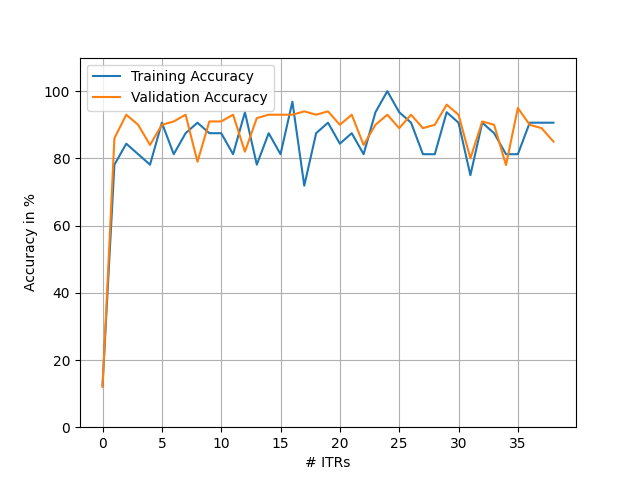

<IPython.core.display.Javascript object>


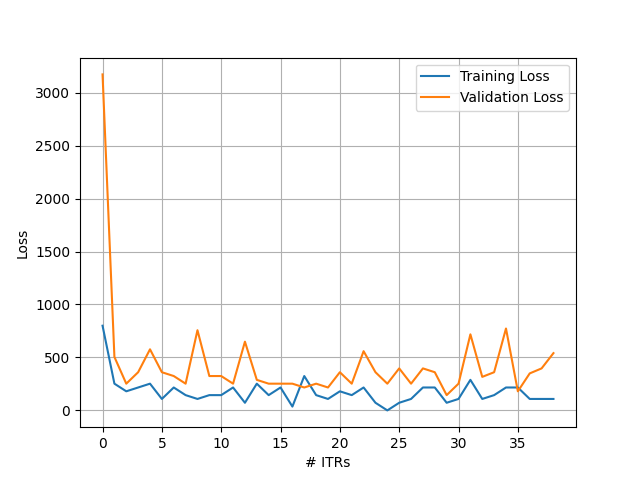

In [116]:
plt.figure()
plt.plot(np.array(trainAccuracy).flatten(), label="Training Accuracy")
plt.plot(np.array(validAccuracy).flatten(), label="Validation Accuracy")
plt.grid()
plt.legend()
plt.ylim(0, 110)
plt.xlabel("# ITRs")
plt.ylabel("Accuracy in %")
plt.show()

plt.figure()
plt.plot(np.array(trainLosses).flatten(), label="Training Loss")
plt.plot(np.array(validLosses).flatten(), label="Validation Loss")
plt.grid()
plt.legend()
plt.xlabel("# ITRs")
plt.ylabel("Loss")
plt.show()

# Observations
### 1) Training accuracy 25%
### 2) Validation accuracy 15% 

<b> Part - (2) : Understanding activation functions </b>

In this part you will learn to use different activation functions for the classification task and compare their performances.

1. Train MNIST digit classification problem with different activation functions i.e. Sigmoid, Tanh, ReLU, LeakyReLU etc. You can stick to stochastic gradient descent optimization algorithm for this part
2. Report the accuray on MNIST test data for all the experiments. Write down your observations in the report.</br>
NOTE: You can use the classification network designed by you from scratch (or) you can build the model using pytorch.



In [68]:
##################################################
#PyTorch implementation
##################################################
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset
torch.manual_seed(6969)

class mnist_classifier(nn.Module):
    
    def __init__(self, input_size, num_classes, activations=["ReLU"]*3, p_dropout=0.0):
        super().__init__()
        self.input_size = input_size
        self.inter_size = 512
        self.nClasses = num_classes
        
        self.FC1 = nn.Linear(self.input_size, self.inter_size)
        self.act1 = eval("nn.{}()".format(activations[0]))
        self.drop1 = nn.Dropout(p=p_dropout)
        
        self.FC2 = nn.Linear(self.inter_size, self.inter_size)
        self.act2 = eval("nn.{}()".format(activations[1]))
        self.drop2 = nn.Dropout(p=p_dropout)
        
        self.FC3 = nn.Linear(self.inter_size, self.inter_size)
        self.act3 = eval("nn.{}()".format(activations[2]))
        self.drop3 = nn.Dropout(p=p_dropout)
        
        self.FC4 = nn.Linear(self.inter_size, self.nClasses)
        
    
    def forward(self, X):
        # INPUT LAYER
        X = X.squeeze(1)
        
        # Layer 1
        X = self.FC1(X)
        X = self.act1(X)
        X = self.drop1(X)
        
        # Layer 2
        X = self.FC2(X)
        X = self.act2(X)
        X = self.drop2(X)
        
        # Layer 3
        X = self.FC3(X)
        X = self.act3(X)
        X = self.drop3(X)
        
        # Layer 4, OUTPUT LAYER
        op = self.FC4(X)
        return op

def validate(net, X, Y, batchSize=32, device="cpu"):
    X_batched, Y_batched = create_batches(X, Y, batchSize)
    acc = 0
    los = 0
    
    with torch.no_grad():
        for i, (X_b, Y_b) in enumerate(zip(X_batched, Y_batched)):
            x = torch.FloatTensor(X_b).to(device)
            y = torch.Tensor(Y_b).to(device)
            
            outputs = net(x)

            loss = criterion(outputs, y).sum()
            if device == "cpu":
                los += loss.detach().numpy()
            else:
                los += loss.cpu().detach().numpy()

            acc += torch.sum((torch.argmax(outputs, dim=1) == torch.argmax(y, dim=1)).float())
    acc = 100*acc/X.shape[0]
    if device == "cpu":
        acc = acc.detach().numpy()
    else:
        acc = acc.cpu().detach().numpy()
    
    los = los/X.shape[0]
    
    return acc, los

/home/spcup2022/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [69]:
def trainer(net, X_train, Y_train_one, X_test, Y_test_one, nEpochs=1, batchSize=32, validationFrequency=100, regularisation_constant=0, p_drop=0.0, verbose=True):
    trainLosses = [[]]*nEpochs
    trainAcces = [[]]*nEpochs

    validLosses = [[]]*nEpochs
    validAcces = [[]]*nEpochs
    
    if nEpochs != 1:
        ta, va, tl, vl = trainer(net, X_train, Y_train_one, X_test, Y_test_one, nEpochs=1, batchSize=batchSize, validationFrequency=validationFrequency, regularisation_constant=regularisation_constant, p_drop=p_drop, verbose=verbose)
        trainLosses[0] = tl
        trainAcces[0] = ta
        validLosses[0] = vl
        validAcces[0] = va
        
        ta, va, tl, vl = trainer(net, X_train, Y_train_one, X_test, Y_test_one, nEpochs=nEpochs-1, batchSize=batchSize, validationFrequency=validationFrequency, regularisation_constant=regularisation_constant, p_drop=p_drop, verbose=verbose)
        for e in range(nEpochs-1):
            trainLosses[e+1] = tl[e]
            trainAcces[e+1] = ta[e]
            validLosses[e+1] = vl[e]
            validAcces[e+1] = va[e]
    else:
        for e in range(1):
            if verbose:
                print("EPOCH:- [{}]".format(e+1))
            X_batched, Y_batched = create_batches(X_train, Y_train_one, batchSize)
            for i, (X, Y) in enumerate(zip(X_batched, Y_batched)):
                x = torch.FloatTensor(X).to(device)
                y = torch.Tensor(Y).to(device)

                optimizer.zero_grad()

                outputs = net(x)
                loss = criterion(outputs, y)

                loss = loss.mean()
                

                if (i+1)%validationFrequency == validationFrequency-1 or i == 0:
                    trainAcc = torch.mean((torch.argmax(outputs, dim=1) == torch.argmax(y, dim=1)).float())*100
                    if device == "cpu":
                        trainAcc = trainAcc.detach().numpy()
                        if verbose:
                            print("Training accuracy is {}%, Training Loss is {}".format(np.round(trainAcc, 2), np.round(loss.detach().numpy(), 5)), end=" ")
                    else:
                        trainAcc = trainAcc.cpu().detach().numpy()
                        if verbose:
                            print("Training accuracy is {}%, Training Loss is {}".format(np.round(trainAcc, 2), np.round(loss.cpu().detach().numpy(), 5)), end=" ")
                    trainAcces[e].append(trainAcc)


                    validAcc, validLoss = validate(net, X_test, Y_test_one, batchSize=batchSize, device=device)
                    validAcces[e].append(validAcc)
                    validLosses[e].append(validLoss)
                    if verbose:
                        print("Validation accuracy is {}%, Validation Loss is {}".format(np.round(validAcc, 2), np.round(validLoss, 5)))
                        
                    if device == "cpu":
                        trainLosses[e].append(loss.detach().numpy())
                    else:
                        trainLosses[e].append(loss.cpu().detach().numpy())
                
                weights_norm = sum(p.pow(2.0).sum() if p.requires_grad==True else 0.0 for p in net.parameters())
                loss += regularisation_constant*weights_norm
                
                loss.backward()
                
                optimizer.step()
            if verbose:
                print("")

            for x in net.modules():
                if isinstance(x, nn.Dropout):
                    x.p = p_drop
            if verbose:
                print('Dropout updated to %f' %p_drop)
    return trainAcces, validAcces, trainLosses, validLosses

In [6]:
##################################################
#Train the network with different activation functions
##################################################

device = "cuda:3"
activations = ["ReLU", "LeakyReLU", "Sigmoid", "Tanh", "Softplus", "Hardtanh"]
tA = []
vA = []
tL = []
vL = []
for i, act in enumerate(activations):
    net = mnist_classifier(784, 10, activations=[act]*3)

    net = net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    batchSize = 64
    nEpochs = 5
    regularisation_constant = 0
    validationFrequency = 50
    p_drop = 0.0


    met = trainer(net, X_train, Y_train_one, X_test, Y_test_one, nEpochs=nEpochs, batchSize=batchSize, validationFrequency=validationFrequency, regularisation_constant=regularisation_constant, p_drop=p_drop, verbose=False)
    trainAcces, validAcces, trainLosses, validLosses = met[0][0], met[1][0], met[2][0], met[3][0]
    
    print("Activation:- {}, Training Accuracy:- {}, Training Loss:- {}, Validation Accuracy:- {}, Validation Loss:- {}\n".format(act, np.mean(trainAcces[-1]), np.mean(trainLosses[-1]), np.mean(validAcces[-1]), np.mean(validLosses[-1])))
    tA.append(trainAcces)
    vA.append(validAcces)
    tL.append(trainLosses)
    vL.append(validLosses)

Activation:- ReLU, Training Accuracy:- 80.0, Training Loss:- 0.22317537665367126, Validation Accuracy:- 78.9219970703125, Validation Loss:- 0.01913948472866788

Activation:- LeakyReLU, Training Accuracy:- 78.75, Training Loss:- 0.2159041166305542, Validation Accuracy:- 77.96199798583984, Validation Loss:- 0.017101274704895912

Activation:- Sigmoid, Training Accuracy:- 11.875, Training Loss:- 2.293639898300171, Validation Accuracy:- 11.569999694824219, Validation Loss:- 0.03611934142112732

Activation:- Tanh, Training Accuracy:- 76.875, Training Loss:- 0.6072341203689575, Validation Accuracy:- 73.76800537109375, Validation Loss:- 0.012890390092134477

Activation:- Softplus, Training Accuracy:- 79.6875, Training Loss:- 0.21967685222625732, Validation Accuracy:- 78.2979965209961, Validation Loss:- 0.015253602260751651

Activation:- Hardtanh, Training Accuracy:- 70.9375, Training Loss:- 0.5616748929023743, Validation Accuracy:- 74.89799499511719, Validation Loss:- 0.012427798089087009



<IPython.core.display.Javascript object>


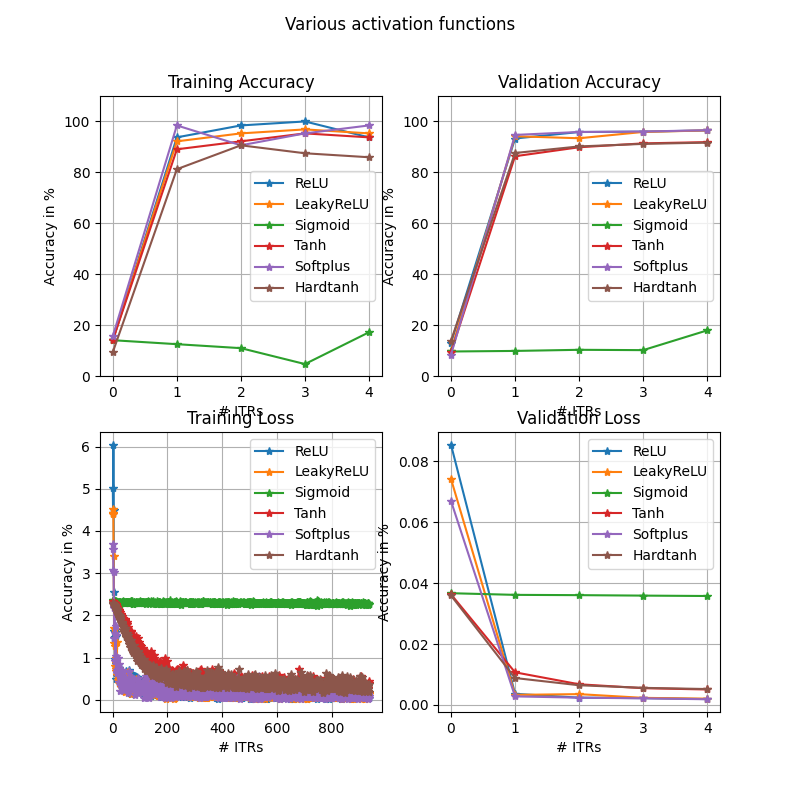

In [7]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.title("Training Accuracy")
for i in range(len(activations)):
    plt.plot(np.array(tA[i]).flatten(), "*-", label=activations[i])
plt.grid()
plt.legend()
plt.ylim(0, 110)
plt.xlabel("# ITRs")
plt.ylabel("Accuracy in %")

plt.subplot(2, 2, 2)
plt.title("Validation Accuracy")
for i in range(len(activations)):
    plt.plot(np.array(vA[i]).flatten(), "*-", label=activations[i])
plt.grid()
plt.legend()
plt.ylim(0, 110)
plt.xlabel("# ITRs")
plt.ylabel("Accuracy in %")

plt.subplot(2, 2, 3)
plt.title("Training Loss")
for i in range(len(activations)):
    plt.plot(np.array(tL[i]).flatten(), "*-", label=activations[i])
plt.grid()
plt.legend()
plt.xlabel("# ITRs")
plt.ylabel("Accuracy in %")

plt.subplot(2, 2, 4)
plt.title("Validation Loss")
for i in range(len(activations)):
    plt.plot(np.array(vL[i]).flatten(), "*-", label=activations[i])
plt.grid()
plt.legend()
plt.xlabel("# ITRs")
plt.ylabel("Loss")

plt.suptitle("Various activation functions")
plt.show()

# Observations
### 1. **Softplus** shows a very good performance.
### 2. Sigmoid has the worst performance since this is limited to 0 and 1
### 3. Softplus also trains very fast.
### 4. LeakyReLU is comparable with softplus.

<b> Part - (3) : Understanding optimization algorithms </b>

In this part you will learn to use different optimiztion algorithm apart from SGD.

1. Using the best activation function from Part - (2), train the classification network using Adam optimization algorithm.
3. Compare the accuracy of the networks trained with SGD and Adam optimization algorithms.
4. Report your observations.

In [9]:
##################################################
#Train the network using Adam optimizer
##################################################

device = "cuda:3"
opts = ["SGD", "Adam", "RMSprop"]
tA = []
vA = []
tL = []
vL = []
for i, opt in enumerate(opts):
    net = mnist_classifier(784, 10, activations=["Softplus"]*3)

    net = net.to(device)

    criterion = nn.CrossEntropyLoss()
    if opt != "SGD":
        optimizer = eval("optim.{}(net.parameters(), lr=0.001)".format(opt))
    else:
        optimizer = eval("optim.{}(net.parameters(), lr=0.001, momentum=0.9)".format(opt))

#     print("Number of trainable parameters:- ", sum(p.numel() for p in net.parameters() if p.requires_grad))


    batchSize = 64
    nEpochs = 5
    regularisation_constant = 0
    validationFrequency = 50
    p_drop = 0.0


    met = trainer(net, X_train, Y_train_one, X_test, Y_test_one, nEpochs=nEpochs, batchSize=batchSize, validationFrequency=validationFrequency, regularisation_constant=regularisation_constant, p_drop=p_drop, verbose=False)
    trainAcces, validAcces, trainLosses, validLosses = met[0][0], met[1][0], met[2][0], met[3][0]
    
    print("Optimizer:- {}, Training Accuracy:- {}, Training Loss:- {}, Validation Accuracy:- {}, Validation Loss:- {}\n".format(opt, np.mean(trainAcces[-1]), np.mean(trainLosses[-1]), np.mean(validAcces[-1]), np.mean(validLosses[-1])))
    tA.append(trainAcces)
    vA.append(validAcces)
    tL.append(trainLosses)
    vL.append(validLosses)

Optimizer:- SGD, Training Accuracy:- 76.25, Training Loss:- 0.23964427411556244, Validation Accuracy:- 79.51200103759766, Validation Loss:- 0.01782366564195603

Optimizer:- Adam, Training Accuracy:- 75.9375, Training Loss:- 0.29188814759254456, Validation Accuracy:- 78.19200134277344, Validation Loss:- 0.021366612613983448

Optimizer:- RMSprop, Training Accuracy:- 79.0625, Training Loss:- 2.3079278469085693, Validation Accuracy:- 76.76199340820312, Validation Loss:- 0.02150404085379094



<IPython.core.display.Javascript object>


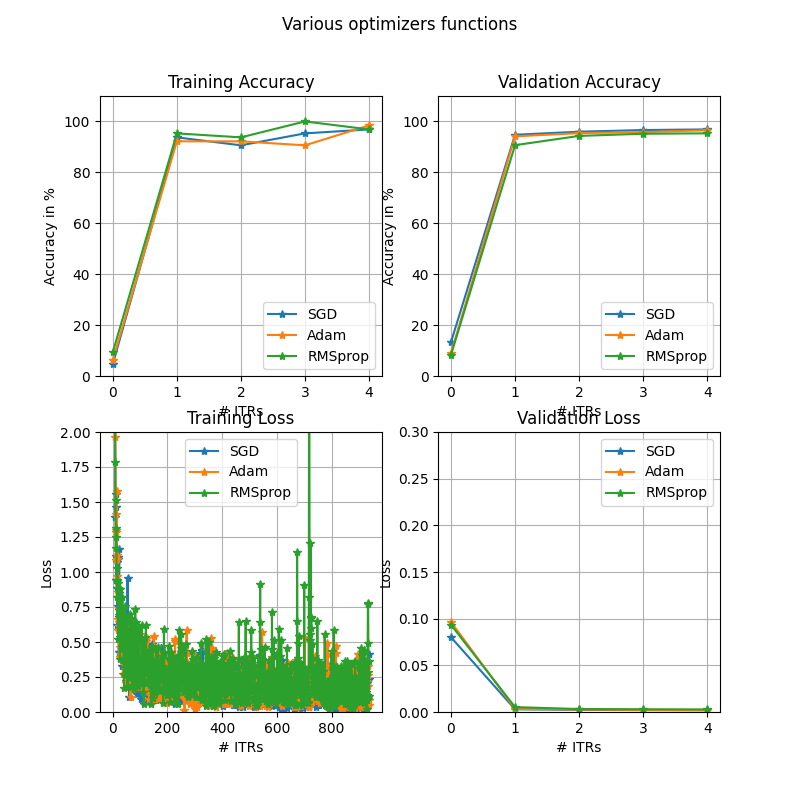

In [10]:
##################################################
#Test the network
##################################################

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.title("Training Accuracy")
for i in range(len(opts)):
    plt.plot(np.array(tA[i]).flatten(), "*-", label=opts[i])
plt.grid()
plt.legend()
plt.ylim(0, 110)
plt.xlabel("# ITRs")
plt.ylabel("Accuracy in %")

plt.subplot(2, 2, 2)
plt.title("Validation Accuracy")
for i in range(len(opts)):
    plt.plot(np.array(vA[i]).flatten(), "*-", label=opts[i])
plt.grid()
plt.legend()
plt.ylim(0, 110)
plt.xlabel("# ITRs")
plt.ylabel("Accuracy in %")

plt.subplot(2, 2, 3)
plt.title("Training Loss")
for i in range(len(opts)):
    plt.plot(np.array(tL[i]).flatten(), "*-", label=opts[i])
plt.grid()
plt.legend()
plt.xlabel("# ITRs")
plt.ylabel("Loss")
plt.ylim(0, 2)

plt.subplot(2, 2, 4)
plt.title("Validation Loss")
for i in range(len(opts)):
    plt.plot(np.array(vL[i]).flatten(), "*-", label=opts[i])
plt.grid()
plt.legend()
plt.xlabel("# ITRs")
plt.ylabel("Loss")
plt.ylim(0, 0.3)
plt.suptitle("Various optimizers functions")
plt.show()


# Observations
### 1. Adam optimizer shows very good performance.
### 2. RMSprop has too much loss.

<b> Part - (4) : Understanding regularization methods </b>

In this part of the assignment, you will learn about a few regularization techniques to reduce the overfitting problem.</br>
Using the above built network, inculcate the following techniques to reduce the overfitting by retraining the network efficiently. Write down the accuracies for each case.

1. Weight regularization
2. Dropout with a probability of 0.5
3. Early stopping


In [12]:
##################################################
#Training with weight regularization
##################################################
lam = [0, 1e-5, 1e-2, 1e-1, 1]
tA = []
vA = []
tL = []
vL = []
for i, l in enumerate(lam):
    net = mnist_classifier(784, 10, activations=["Softplus"]*3)

    net = net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

#     print("Number of trainable parameters:- ", sum(p.numel() for p in net.parameters() if p.requires_grad))


    batchSize = 64
    nEpochs = 5
    regularisation_constant = l
    validationFrequency = 50
    p_drop = 0.0


    met = trainer(net, X_train, Y_train_one, X_test, Y_test_one, nEpochs=nEpochs, batchSize=batchSize, validationFrequency=validationFrequency, regularisation_constant=regularisation_constant, p_drop=p_drop, verbose=False)
    trainAcces, validAcces, trainLosses, validLosses = met[0][0], met[1][0], met[2][0], met[3][0]
    
    print("Regularisation constant:- {}, Training Accuracy:- {}, Training Loss:- {}, Validation Accuracy:- {}, Validation Loss:- {}\n".format(l, np.mean(trainAcces[-1]), np.mean(trainLosses[-1]), np.mean(validAcces[-1]), np.mean(validLosses[-1])))
    tA.append(trainAcces)
    vA.append(validAcces)
    tL.append(trainLosses)
    vL.append(validLosses)

Regularisation constant:- 0, Training Accuracy:- 76.5625, Training Loss:- 0.26304179430007935, Validation Accuracy:- 78.4699935913086, Validation Loss:- 0.01930303682662547

Regularisation constant:- 1e-05, Training Accuracy:- 78.75, Training Loss:- 0.2535783350467682, Validation Accuracy:- 77.64599609375, Validation Loss:- 0.016821105314083398

Regularisation constant:- 0.01, Training Accuracy:- 74.375, Training Loss:- 0.28108200430870056, Validation Accuracy:- 76.70799255371094, Validation Loss:- 0.016420445913523436

Regularisation constant:- 0.1, Training Accuracy:- 76.25, Training Loss:- 0.43003347516059875, Validation Accuracy:- 74.83199310302734, Validation Loss:- 0.02339934726014733

Regularisation constant:- 1, Training Accuracy:- 54.375, Training Loss:- 1.226213812828064, Validation Accuracy:- 52.209999084472656, Validation Loss:- 0.03543319977641106



<IPython.core.display.Javascript object>


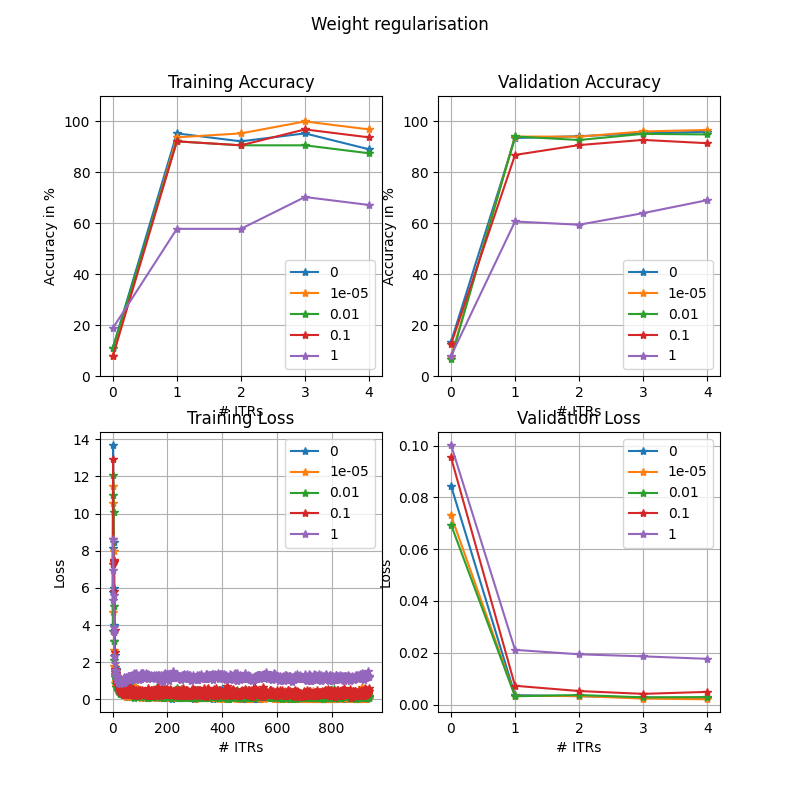

In [13]:
##################################################
#Test the network
##################################################

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.title("Training Accuracy")
for i in range(len(lam)):
    plt.plot(np.array(tA[i]).flatten(), "*-", label=lam[i])
plt.grid()
plt.legend()
plt.ylim(0, 110)
plt.xlabel("# ITRs")
plt.ylabel("Accuracy in %")

plt.subplot(2, 2, 2)
plt.title("Validation Accuracy")
for i in range(len(lam)):
    plt.plot(np.array(vA[i]).flatten(), "*-", label=lam[i])
plt.grid()
plt.legend()
plt.ylim(0, 110)
plt.xlabel("# ITRs")
plt.ylabel("Accuracy in %")

plt.subplot(2, 2, 3)
plt.title("Training Loss")
for i in range(len(lam)):
    plt.plot(np.array(tL[i]).flatten(), "*-", label=lam[i])
plt.grid()
plt.legend()
plt.xlabel("# ITRs")
plt.ylabel("Loss")
# plt.ylim(0, 10)

plt.subplot(2, 2, 4)
plt.title("Validation Loss")
for i in range(len(lam)):
    plt.plot(np.array(vL[i]).flatten(), "*-", label=lam[i])
plt.grid()
plt.legend()
plt.xlabel("# ITRs")
plt.ylabel("Loss")
# plt.ylim(0, 0.3)
plt.suptitle("Weight regularisation")
plt.show()


In [14]:
##################################################
#Training with dropout strategy
##################################################
p = [0, 0.2, 0.3, 0.4, 0.5]
tA = []
vA = []
tL = []
vL = []
for i, p_drop in enumerate(p):
    net = mnist_classifier(784, 10, activations=["Softplus"]*3)

    net = net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

#     print("Number of trainable parameters:- ", sum(p.numel() for p in net.parameters() if p.requires_grad))


    batchSize = 64
    nEpochs = 5
    regularisation_constant = l
    validationFrequency = 50


    met = trainer(net, X_train, Y_train_one, X_test, Y_test_one, nEpochs=nEpochs, batchSize=batchSize, validationFrequency=validationFrequency, regularisation_constant=regularisation_constant, p_drop=p_drop, verbose=False)
    trainAcces, validAcces, trainLosses, validLosses = met[0][0], met[1][0], met[2][0], met[3][0]
    
    print("Dropout:- {}, Training Accuracy:- {}, Training Loss:- {}, Validation Accuracy:- {}, Validation Loss:- {}\n".format(p_drop, np.mean(trainAcces[-1]), np.mean(trainLosses[-1]), np.mean(validAcces[-1]), np.mean(validLosses[-1])))
    tA.append(trainAcces)
    vA.append(validAcces)
    tL.append(trainLosses)
    vL.append(validLosses)

Dropout:- 0, Training Accuracy:- 50.3125, Training Loss:- 1.23683500289917, Validation Accuracy:- 53.21600341796875, Validation Loss:- 0.031796290193796165

Dropout:- 0.2, Training Accuracy:- 53.125, Training Loss:- 1.229280710220337, Validation Accuracy:- 53.11800003051758, Validation Loss:- 0.03358901462078094

Dropout:- 0.3, Training Accuracy:- 49.6875, Training Loss:- 1.2249354124069214, Validation Accuracy:- 52.70600128173828, Validation Loss:- 0.029823231213092806

Dropout:- 0.4, Training Accuracy:- 52.8125, Training Loss:- 1.244251012802124, Validation Accuracy:- 54.96799850463867, Validation Loss:- 0.029947792778015136

Dropout:- 0.5, Training Accuracy:- 59.375, Training Loss:- 1.2361739873886108, Validation Accuracy:- 54.597999572753906, Validation Loss:- 0.029888892108201982



<IPython.core.display.Javascript object>


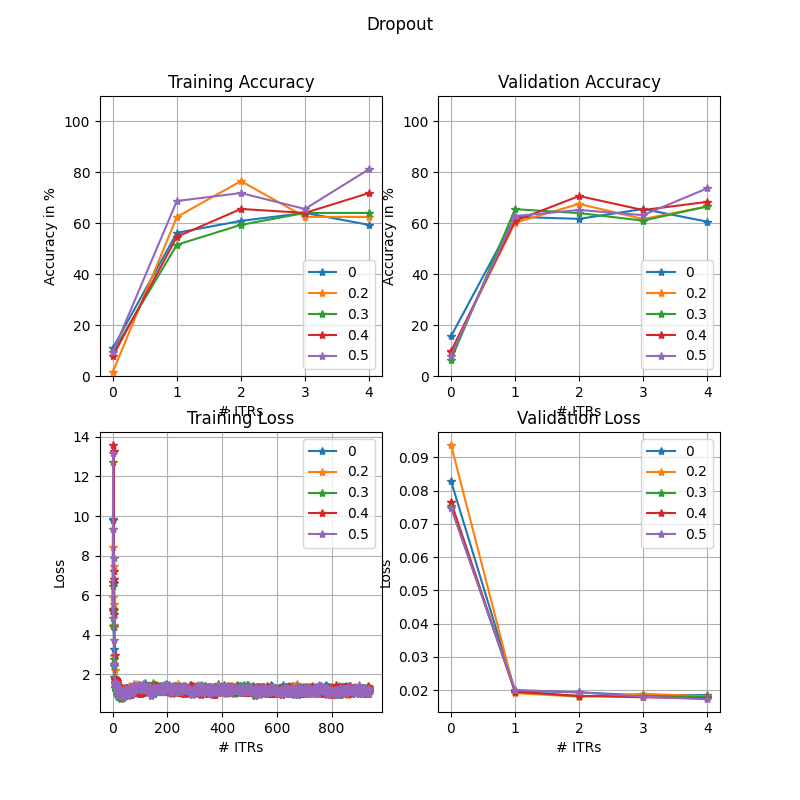

In [15]:
##################################################
#Test the network
##################################################

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.title("Training Accuracy")
for i in range(len(p)):
    plt.plot(np.array(tA[i]).flatten(), "*-", label=p[i])
plt.grid()
plt.legend()
plt.ylim(0, 110)
plt.xlabel("# ITRs")
plt.ylabel("Accuracy in %")

plt.subplot(2, 2, 2)
plt.title("Validation Accuracy")
for i in range(len(p)):
    plt.plot(np.array(vA[i]).flatten(), "*-", label=p[i])
plt.grid()
plt.legend()
plt.ylim(0, 110)
plt.xlabel("# ITRs")
plt.ylabel("Accuracy in %")

plt.subplot(2, 2, 3)
plt.title("Training Loss")
for i in range(len(p)):
    plt.plot(np.array(tL[i]).flatten(), "*-", label=p[i])
plt.grid()
plt.legend()
plt.xlabel("# ITRs")
plt.ylabel("Loss")
# plt.ylim(0, 10)

plt.subplot(2, 2, 4)
plt.title("Validation Loss")
for i in range(len(p)):
    plt.plot(np.array(vL[i]).flatten(), "*-", label=p[i])
plt.grid()
plt.legend()
plt.xlabel("# ITRs")
plt.ylabel("Loss")
# plt.ylim(0, 0.3)
plt.suptitle("Dropout")
plt.show()


In [197]:
##################################################
#Training with early stopping criterion
##################################################
device = "cuda:3"

net = mnist_classifier(784, 10, activations=["Softplus"]*3)

net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

patience = 3
q = []

batchSize = 64
max_epochs = 50
regularisation_constant = 0
validationFrequency = 50
p_drop = 0.0

tA = []
tL = []
vA = []
vL = []

step = 0
prev_valid = 0
while step < max_epochs and len(q) < patience:
    print("Epoch {}".format(step+1), end=" ")
    met = trainer(net, X_train, Y_train_one, X_test, Y_test_one, nEpochs=1, batchSize=batchSize, validationFrequency=validationFrequency, regularisation_constant=regularisation_constant, p_drop=p_drop, verbose=False)
    trainAcces, validAcces, trainLosses, validLosses = met[0][0], met[1][0], met[2][0], met[3][0]

    tA.append(trainAcces)
    vA.append(validAcces)
    tL.append(trainLosses)
    vL.append(validLosses)
    if prev_valid < validLosses[-1]:
        q.append(validLosses[-1])
    else:
        q = []
    print("Training Accuracy {}, Taining Loss {}, Validation Accuracy {}, Validation Loss {}".format(trainAcces[-1], trainLosses[-1], validAcces[-1], validLosses[-1]))

    prev_valid = validLosses[-1]
    step += 1
print(q)

Epoch 1 Training Accuracy 92.1875, Taining Loss 0.3568825125694275, Validation Accuracy 95.82999420166016, Validation Loss 0.002411318730376661
Epoch 2 Training Accuracy 92.1875, Taining Loss 0.24771127104759216, Validation Accuracy 96.8499984741211, Validation Loss 0.0020749594632536172
Epoch 3 Training Accuracy 98.4375, Taining Loss 0.06596782803535461, Validation Accuracy 97.47999572753906, Validation Loss 0.0015813511432148516
Epoch 4 Training Accuracy 95.3125, Taining Loss 0.11047233641147614, Validation Accuracy 97.64999389648438, Validation Loss 0.0017313995127566158
Epoch 5 Training Accuracy 98.4375, Taining Loss 0.07290776818990707, Validation Accuracy 97.69999694824219, Validation Loss 0.001763959439296741
Epoch 6 Training Accuracy 100.0, Taining Loss 0.014430050738155842, Validation Accuracy 97.93999481201172, Validation Loss 0.0017925992937758565
[0.0017313995127566158, 0.001763959439296741, 0.0017925992937758565]


<IPython.core.display.Javascript object>


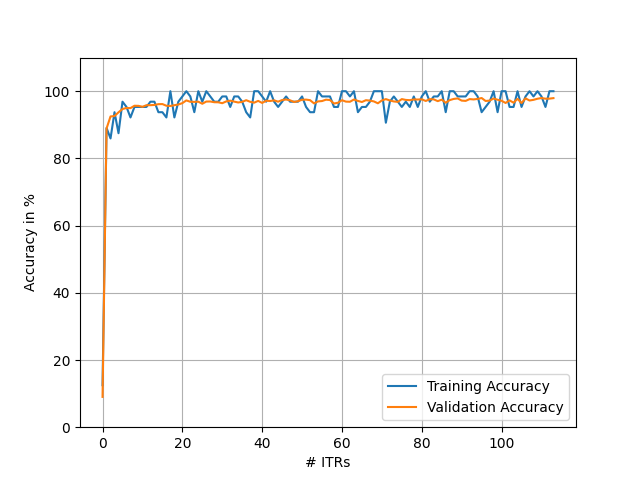

<IPython.core.display.Javascript object>


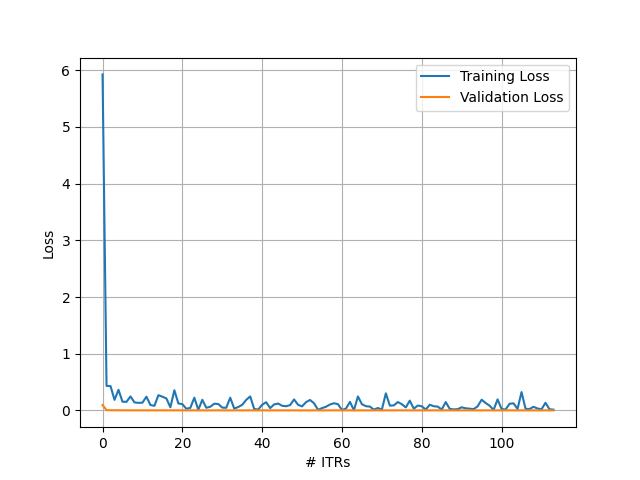

In [198]:
plt.figure()
plt.plot(np.array(tA).flatten(), label="Training Accuracy")
plt.plot(np.array(vA).flatten(), label="Validation Accuracy")
plt.grid()
plt.legend()
plt.ylim(0, 110)
plt.xlabel("# ITRs")
plt.ylabel("Accuracy in %")
plt.show()

plt.figure()
plt.plot(np.array(tL).flatten(), label="Training Loss")
plt.plot(np.array(vL).flatten(), label="Validation Loss")
plt.grid()
plt.legend()
plt.xlabel("# ITRs")
plt.ylabel("Loss")
plt.show()


# Observations
### 1. Having weight regularisation has increased performance, 1e-5 is the optimal value.
### 2. Dropout of 0.5 has drastically increased the performance.
### 3. Introducing early stopping has increased performance, Training acc of 100% and validation acc of 98%. In previous implementation validation accuracy was in betwem 96-97%

<b> Part - (5) : Understanding vanishing gradients problem </b> </br>
Use the best trained models in part (4) to understand the problem of vanishing gradient.
1. Plot the norm of the gradients for various layers with/without weight regularization
3. Repeat the same experiments with skip connections. You can choose your desired skip connections in the network by increasing the number of hidden layers.
4. Report your observations on the differences between the plots in the above two cases.

In [18]:
class mnist_classifier_deeper(nn.Module):
    
    def __init__(self, input_size, num_classes, activations=["ReLU"]*6, p_dropout=0.0, skip_connec=True):
        super().__init__()
        self.input_size = input_size
        self.inter_size = 512
        self.nClasses = num_classes
        self.skip_connec = skip_connec
        
        self.FC1 = nn.Linear(self.input_size, self.inter_size)
        self.act1 = eval("nn.{}()".format(activations[0]))
        self.drop1 = nn.Dropout(p=p_dropout)
        
        self.FC2 = nn.Linear(self.inter_size, self.inter_size)
        self.act2 = eval("nn.{}()".format(activations[1]))
        self.drop2 = nn.Dropout(p=p_dropout)
        
        self.FC3 = nn.Linear(self.inter_size, self.inter_size)
        self.act3 = eval("nn.{}()".format(activations[2]))
        self.drop3 = nn.Dropout(p=p_dropout)
        
        self.FC4 = nn.Linear(self.inter_size, self.inter_size)
        self.act4 = eval("nn.{}()".format(activations[3]))
        self.drop4 = nn.Dropout(p=p_dropout)
        
        self.FC5 = nn.Linear(self.inter_size, self.inter_size)
        self.act5 = eval("nn.{}()".format(activations[4]))
        self.drop5 = nn.Dropout(p=p_dropout)
        
        self.FC6 = nn.Linear(self.inter_size, self.inter_size)
        self.act6 = eval("nn.{}()".format(activations[5]))
        self.drop6 = nn.Dropout(p=p_dropout)
        
        self.FC7 = nn.Linear(self.inter_size, self.nClasses)
        
    
    def forward(self, X):
        # INPUT LAYER
        X = X.squeeze(1)
        
        # Layer 1
        X = self.FC1(X)
        skip1 = self.act1(X)
        X = self.drop1(skip1)
        
        # Layer 2
        X = self.FC2(X)
        skip2 = self.act2(X)
        X = self.drop2(skip2)
        
        # Layer 3
        X = self.FC3(X + skip1) if self.skip_connec else self.FC3(X)
        skip3 = self.act3(X)
        X = self.drop3(skip3)
        
        # Layer 4
        X = self.FC4(X + skip2) if self.skip_connec else self.FC4(X)
        skip4 = self.act4(X)
        X = self.drop4(skip4)
        
        # Layer 5
        X = self.FC5(X + skip3) if self.skip_connec else self.FC5(X)
        skip5 = self.act5(X)
        X = self.drop5(skip5)
        
        # Layer 6
        X = self.FC6(X + skip4) if self.skip_connec else self.FC6(X)
        skip6 = self.act6(X)
        X = self.drop6(skip6)
        
        # Layer 7, OUTPUT LAYER
        op = self.FC7(X + skip5) if self.skip_connec else self.FC7(X)
        return op

In [19]:
def trainer_deeper(net, X_train, Y_train_one, X_test, Y_test_one, nEpochs=1, batchSize=32, validationFrequency=100, regularisation_constant=0, p_drop=0.0, verbose=True):
    trainLosses = [[]]*nEpochs
    trainAcces = [[]]*nEpochs

    validLosses = [[]]*nEpochs
    validAcces = [[]]*nEpochs
    
    wn = [[]]*nEpochs
    if nEpochs != 1:
        ta, va, tl, vl, wen = trainer_deeper(net, X_train, Y_train_one, X_test, Y_test_one, nEpochs=1, batchSize=batchSize, validationFrequency=validationFrequency, regularisation_constant=regularisation_constant, p_drop=p_drop, verbose=verbose)
        trainLosses[0] = tl
        trainAcces[0] = ta
        validLosses[0] = vl
        validAcces[0] = va
        wn[0] = wen
        
        ta, va, tl, vl, wen = trainer_deeper(net, X_train, Y_train_one, X_test, Y_test_one, nEpochs=nEpochs-1, batchSize=batchSize, validationFrequency=validationFrequency, regularisation_constant=regularisation_constant, p_drop=p_drop, verbose=verbose)
        for e in range(nEpochs-1):
            trainLosses[e+1] = tl[e]
            trainAcces[e+1] = ta[e]
            validLosses[e+1] = vl[e]
            validAcces[e+1] = va[e]
            wn[e+1] = wen[e]
    else:
        for e in range(1):
            if verbose:
                print("EPOCH:- [{}]".format(e+1))
            X_batched, Y_batched = create_batches(X_train, Y_train_one, batchSize)
            for i, (X, Y) in enumerate(zip(X_batched, Y_batched)):
                x = torch.FloatTensor(X).to(device)
                y = torch.Tensor(Y).to(device)

                optimizer.zero_grad()

                outputs = net(x)
                loss = criterion(outputs, y)

                loss = loss.mean()
                

                if (i+1)%validationFrequency == validationFrequency-1 or i == 0:
                    trainAcc = torch.mean((torch.argmax(outputs, dim=1) == torch.argmax(y, dim=1)).float())*100
        #             trainAcc = None
                    if device == "cpu":
                        trainAcc = trainAcc.detach().numpy()
                        if verbose:
                            print("Training accuracy is {}%, Training Loss is {}".format(np.round(trainAcc, 2), np.round(loss.detach().numpy(), 5)), end=" ")
                    else:
                        trainAcc = trainAcc.cpu().detach().numpy()
                        if verbose:
                            print("Training accuracy is {}%, Training Loss is {}".format(np.round(trainAcc, 2), np.round(loss.cpu().detach().numpy(), 5)), end=" ")
                    trainAcces[e].append(trainAcc)
                    
                    if device == "cpu":
                        trainLosses[e].append(loss.detach().numpy())
                    else:
                        trainLosses[e].append(loss.cpu().detach().numpy())


                    validAcc, validLoss = validate(net, X_test, Y_test_one, batchSize=batchSize, device=device)
                    validAcces[e].append(validAcc)
                    validLosses[e].append(validLoss)
                    if verbose:
                        print("Validation accuracy is {}%, Validation Loss is {}".format(np.round(validAcc, 2), np.round(validLoss, 5)))
                
                weights_norms = [p.pow(2.0).sum() if p.requires_grad==True else 0.0 for p in net.parameters()]
                wn[e].append([d.cpu().detach().numpy() for d in weights_norms])
                loss += regularisation_constant*sum(weights_norms)
                
                loss.backward()
                
                optimizer.step()
            if verbose:
                print("")

            for x in net.modules():
                if isinstance(x, nn.Dropout):
                    x.p = p_drop
            if verbose:
                print('Dropout updated to %f' %p_drop)
    return trainAcces, validAcces, trainLosses, validLosses, wn

In [20]:
##################################################
#Plots without skip connections
##################################################
net = mnist_classifier_deeper(784, 10, activations=["Softplus"]*6, skip_connec=False)

net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

print("Number of trainable parameters:- ", sum(p.numel() for p in net.parameters() if p.requires_grad))


batchSize = 64
nEpochs = 5
regularisation_constant = 1e-5
validationFrequency = 50
p_drop = 0.5

met = trainer_deeper(net, X_train, Y_train_one, X_test, Y_test_one, nEpochs=nEpochs, batchSize=batchSize, validationFrequency=validationFrequency, regularisation_constant=regularisation_constant, p_drop=p_drop, verbose=False)
ws_trainAcces, ws_validAcces, ws_trainLosses, ws_validLosses, ws_weights_norms = met[0][0], met[1][0], met[2][0], met[3][0], met[4][0][0]

Number of trainable parameters:-  1720330


In [21]:
##################################################
#Plots with skip connections
##################################################
net = mnist_classifier_deeper(784, 10, activations=["Softplus"]*6, skip_connec=True)

net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

print("Number of trainable parameters:- ", sum(p.numel() for p in net.parameters() if p.requires_grad))


batchSize = 64
nEpochs = 5
regularisation_constant = 1e-5
validationFrequency = 50
p_drop = 0.5

met = trainer_deeper(net, X_train, Y_train_one, X_test, Y_test_one, nEpochs=nEpochs, batchSize=batchSize, validationFrequency=validationFrequency, regularisation_constant=regularisation_constant, p_drop=p_drop, verbose=False)
s_trainAcces, s_validAcces, s_trainLosses, s_validLosses, s_weights_norms = met[0][0], met[1][0], met[2][0], met[3][0], met[4][0][0]

Number of trainable parameters:-  1720330


<IPython.core.display.Javascript object>


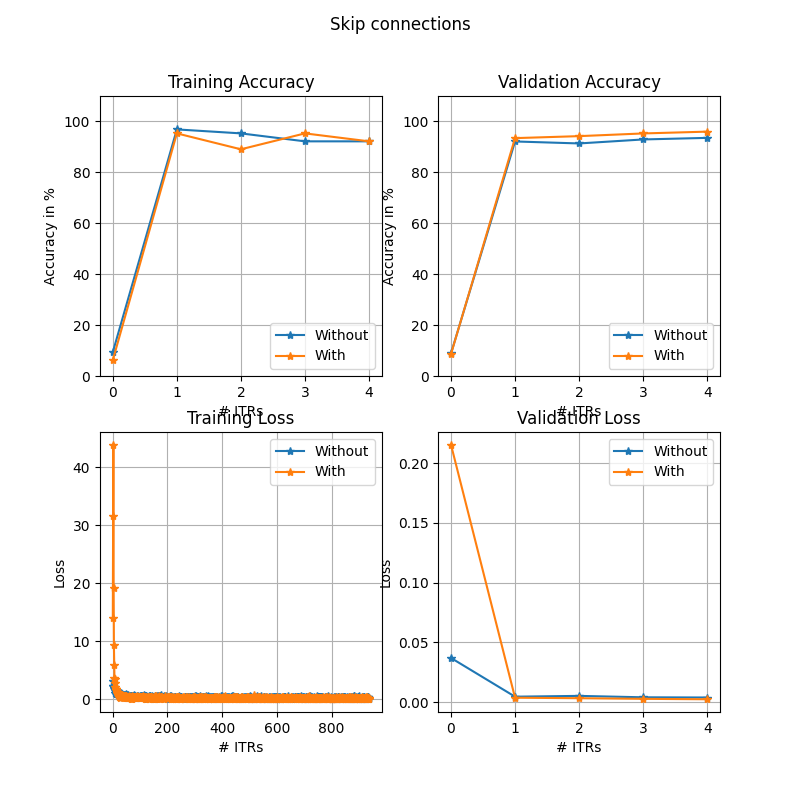

<IPython.core.display.Javascript object>


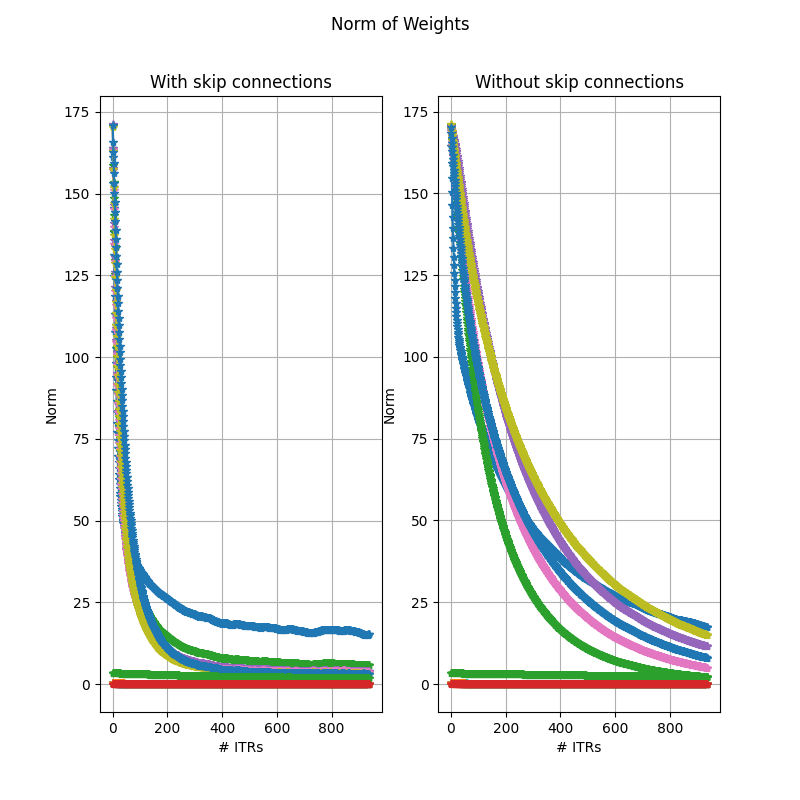

In [23]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.title("Training Accuracy")
plt.plot(np.array(ws_trainAcces[0]).flatten(), "*-", label="Without")
plt.plot(np.array(s_trainAcces[0]).flatten(), "*-", label="With")
plt.grid()
plt.legend()
plt.ylim(0, 110)
plt.xlabel("# ITRs")
plt.ylabel("Accuracy in %")

plt.subplot(2, 2, 2)
plt.title("Validation Accuracy")
plt.plot(np.array(ws_validAcces[0]).flatten(), "*-", label="Without")
plt.plot(np.array(s_validAcces[0]).flatten(), "*-", label="With")
plt.grid()
plt.legend()
plt.ylim(0, 110)
plt.xlabel("# ITRs")
plt.ylabel("Accuracy in %")

plt.subplot(2, 2, 3)
plt.title("Training Loss")
plt.plot(np.array(ws_trainLosses[0]).flatten(), "*-", label="Without")
plt.plot(np.array(s_trainLosses[0]).flatten(), "*-", label="With")
plt.grid()
plt.legend()
plt.xlabel("# ITRs")
plt.ylabel("Loss")
# plt.ylim(0, 10)

plt.subplot(2, 2, 4)
plt.title("Validation Loss")
plt.plot(np.array(ws_validLosses[0]).flatten(), "*-", label="Without")
plt.plot(np.array(s_validLosses[0]).flatten(), "*-", label="With")
plt.grid()
plt.legend()
plt.xlabel("# ITRs")
plt.ylabel("Loss")
# plt.ylim(0, 0.3)
plt.suptitle("Skip connections")
plt.show()


ws_weights_norms = np.array(ws_weights_norms)
s_weights_norms = np.array(s_weights_norms)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.title("With skip connections")
for i in range(ws_weights_norms.shape[1]):
    plt.plot(ws_weights_norms[:, i], "*-")
plt.grid()
plt.xlabel("# ITRs")
plt.ylabel("Norm")

plt.subplot(1, 2, 2)
plt.title("Without skip connections")
for i in range(s_weights_norms.shape[1]):
    plt.plot(s_weights_norms[:, i], "*-")
plt.grid()
plt.xlabel("# ITRs")
plt.ylabel("Norm")

plt.suptitle("Norm of Weights")
plt.show()

# Observations
### 1. Introducing skip connections has increased the speed of training and also accuracy has been improved.

# Final observations
## In Assignment 1, We have used kNN - classifier and was able acheive up to 40% but using complicated neural network we were able to get upto 98%.
## But we still fail in 2% of dataset, using low dimension images of size 28x28 we are stll confused with many instances. Thus we need to look into different methods to solve this, CNNs are such a architectures.